# Análisis del uso de Bicicletas públicas en Londres

Este dataset contiene registros del uso de bicicletas públicas  en la ciudad de Londres durante dos años, desde el 04/Ene/2015 hasta el día 03/Ene/2017.  

Para cada día se cuenta con información acerca del horario en el que se uso, las condiciones metereologicas, la estación del año, datos de temperatura y humedad. 

Nuestro cliente quiere poder predecir el uso de las bicicletas con los datos aportados. 

## Objetivos del Análisis

**1. Predecir el uso de las bicicletas con los datos aportados**

Se explorará cómo y cuáles son los factores que influyen en el uso de la bicicleta en la ciudad de Londres, respondiendo a las siguientes preguntas: 

**Preguntas**
1. ¿Cuáles son los meses en los cuales se utilizan más bicicletas?
2. ¿Cómo varia el uso de bicicletas durante el transcurso del día?
3. ¿Cómo varia el uso de bicicletas con las estaciones del año?
4. ¿Cómo afecta el clima el uso de la bicicleta?
5. ¿Cuando se usan más bicicletas durante el fin de semana, festivos o en los días laborales?
6. ¿Cuál es el día de la semana en el que más se usan bicicletas
7. ¿Afecta la temperatura en el uso de la bicicleta?
8. ¿Afecta la humedad el uso de la bicicleta?
9. ¿Se ha aumentado el uso de bicicletas en Londres a traves del tiempo?

## Importar y entender el dataset used_bikes.csv 

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

path = 'data/used_bikes.csv'
df = pd.read_csv(path, sep=",", parse_dates=["timestamp"])
print(df.info())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            17414 non-null  datetime64[ns]
 1   real_temperature     17414 non-null  float64       
 2   feeling_temperature  17414 non-null  float64       
 3   humidity             17414 non-null  float64       
 4   wind_speed           17414 non-null  float64       
 5   weather              17414 non-null  object        
 6   is_holiday           17414 non-null  float64       
 7   is_weekend           17414 non-null  float64       
 8   season               17414 non-null  object        
 9   used_bikes           17414 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 1.3+ MB
None
            timestamp  real_temperature  feeling_temperature  humidity  \
0 2015-01-04 00:00:00               3.0        

**Observaciones** 

- El dataset contiene 17414 registros y 10 columnas. 
- Las unidad de medida para la temperatura es  para las columnas **real_temperature** and **feeling_temperature**  es °C.  
- Columna **is_holiday:** 1 si es festivo, 0 si no es festivo. 
- Columna **is_weekend:** 1 si es fin de semana, 0 si no lo es
- Columna **wind_speed:** velocidad del viento en km/h
- Podemos identificar variables de tipo catégorico y numérico. 
- Todas las columnas del dataset tienen la misma cantidad de registros, al parecer no hay valores faltantes. 
- Para continuar con la limpieza de datos seguiremos los siguientes pasos: 
    * Dividir la columna timestamp: La columna timestamp contiene la fecha y la hora, asi que procederemos a separar esos valores en dos columnas nuevas llamadas date and time. 
    * Agregar una nueva columna llamada **time_of_day** usando la columna **time** creando cuatro categorias:
<code>
        - morning:   ["05:00:00", "12:00:00"]
        - afternoon: ["12:00:00", "17:00:00"]
        - evening:   ["17:00:00", "21:00:00"]
        - night:     ["21:00:00", "04:00:00"]
        - dawn:      ["00:00:00", "04:00:00"]
</code>
    * Agregar una nueva columna llamada **year** usando la columna **date** 
    * Analizar columnas con variables catégoricas y numéricas. 
    * Registros repetidos
    * Valores extremos (outliers) en el caso de las variables numéricas. 

## Limpiar el dataset 

### Dividir la columna timestamp. 
- Dividir timestamp en dos date and time. 
- Convertir la columna is_holiday and is_weekend a integer. 

In [251]:
# Crear dos columnas date and time usando la columna timestamp
df['date'] = df.timestamp.dt.date
df['time'] = df.timestamp.dt.time

df['date'] = pd.to_datetime(df['date'])
df['time'] = df['time'].astype(str)

# Eliminar la columna timestamp
df.drop('timestamp', axis=1, inplace=True)

### Agregar columna time_of_day 

Con el objetivo de crear la clasificación dependiendo de la hora del día, al final obtendremos cinco categorias:    
- morning 
- afternoon 
- evening 
- night  
- dawn 

In [252]:
def set_time_of_day(start, end, label):
    df.loc[pd.to_timedelta(df["time"]).between(start, end),
           'time_segment'] = label


set_time_of_day("05:00:00", "12:00:00", "morning")
set_time_of_day("12:01:00", "17:00:00", "afternoon")
set_time_of_day("17:01:00", "21:00:00", "evening")
set_time_of_day("21:01:00", "24:00:00", "night")
set_time_of_day("00:00:00", "04:00:00", "dawn")

### Obtener más datos de la columna date
Vamos a crear nuevas columnas usando la columna date, con esta información podemos obtener el año, mes y día, el objetivos es poder determinar relaciones entre los dias de la semana y el mes en los que se usan las bicicletas. 

In [253]:
df["year"] = df.date.dt.year
df["month"] = df.date.dt.month
df["day_name"] = df.date.dt.day_name()
df["day"] = df.date.dt.day

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   real_temperature     17414 non-null  float64       
 1   feeling_temperature  17414 non-null  float64       
 2   humidity             17414 non-null  float64       
 3   wind_speed           17414 non-null  float64       
 4   weather              17414 non-null  object        
 5   is_holiday           17414 non-null  float64       
 6   is_weekend           17414 non-null  float64       
 7   season               17414 non-null  object        
 8   used_bikes           17414 non-null  int64         
 9   date                 17414 non-null  datetime64[ns]
 10  time                 17414 non-null  object        
 11  time_segment         17414 non-null  object        
 12  year                 17414 non-null  int64         
 13  month                17414 non-

### Analizar columnas con variables catégoricas y numéricas. 

El dataset contiene dos columnas para clasificar si los días de uso de la bicicleta son fines de semana o días festivos,  con base en esa columna vamos a crear una nueva columna llamada **is_weekday** para identificar el uso de bicicleta en días no festivos o fines de semana. 

In [255]:
#0 = weekday
#1 = weekend
#2 = holiday
def is_weekday(weekend_var, holiday_var):
    if (weekend_var == 0) & (holiday_var == 0):
        return 0
    elif (weekend_var == 1):
        return 1
    elif (holiday_var == 1):
        return 2


df["day_type"] = df.apply(
    lambda x: is_weekday(x["is_weekend"], x["is_holiday"]), axis=1)

In [256]:
df.drop(["is_weekend", "is_holiday"], axis=1, inplace=True)

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   real_temperature     17414 non-null  float64       
 1   feeling_temperature  17414 non-null  float64       
 2   humidity             17414 non-null  float64       
 3   wind_speed           17414 non-null  float64       
 4   weather              17414 non-null  object        
 5   season               17414 non-null  object        
 6   used_bikes           17414 non-null  int64         
 7   date                 17414 non-null  datetime64[ns]
 8   time                 17414 non-null  object        
 9   time_segment         17414 non-null  object        
 10  year                 17414 non-null  int64         
 11  month                17414 non-null  int64         
 12  day_name             17414 non-null  object        
 13  day                  17414 non-

Verificar los subniveles de las variables categóricas, con el fin de establecer si existen más de dos niveles por columna y si es posible unificar valores. 

In [258]:
# Conteo de los niveles en las diferentes columnas categóricas
cols_cat = ['season', 'weather', 'time_segment', 'day_name', 'day_type']

for col in cols_cat:
  print(f'Columna {col}: {df[col].nunique()} subniveles')

Columna season: 4 subniveles
Columna weather: 7 subniveles
Columna time_segment: 5 subniveles
Columna day_name: 7 subniveles
Columna day_type: 3 subniveles


Podemos observar que las columnas tienen dos ó más subniveles.  Para conocer el nombre de los subniveles vamos a graficar e identificar que no existen duplicados o valores con errores typográficos. 

In [259]:
# Define styles for graphs
color = "blend:#7AB,#EDA"
sns.set_theme(style="whitegrid",
              font="Verdana",
              palette=color,
              font_scale=1)

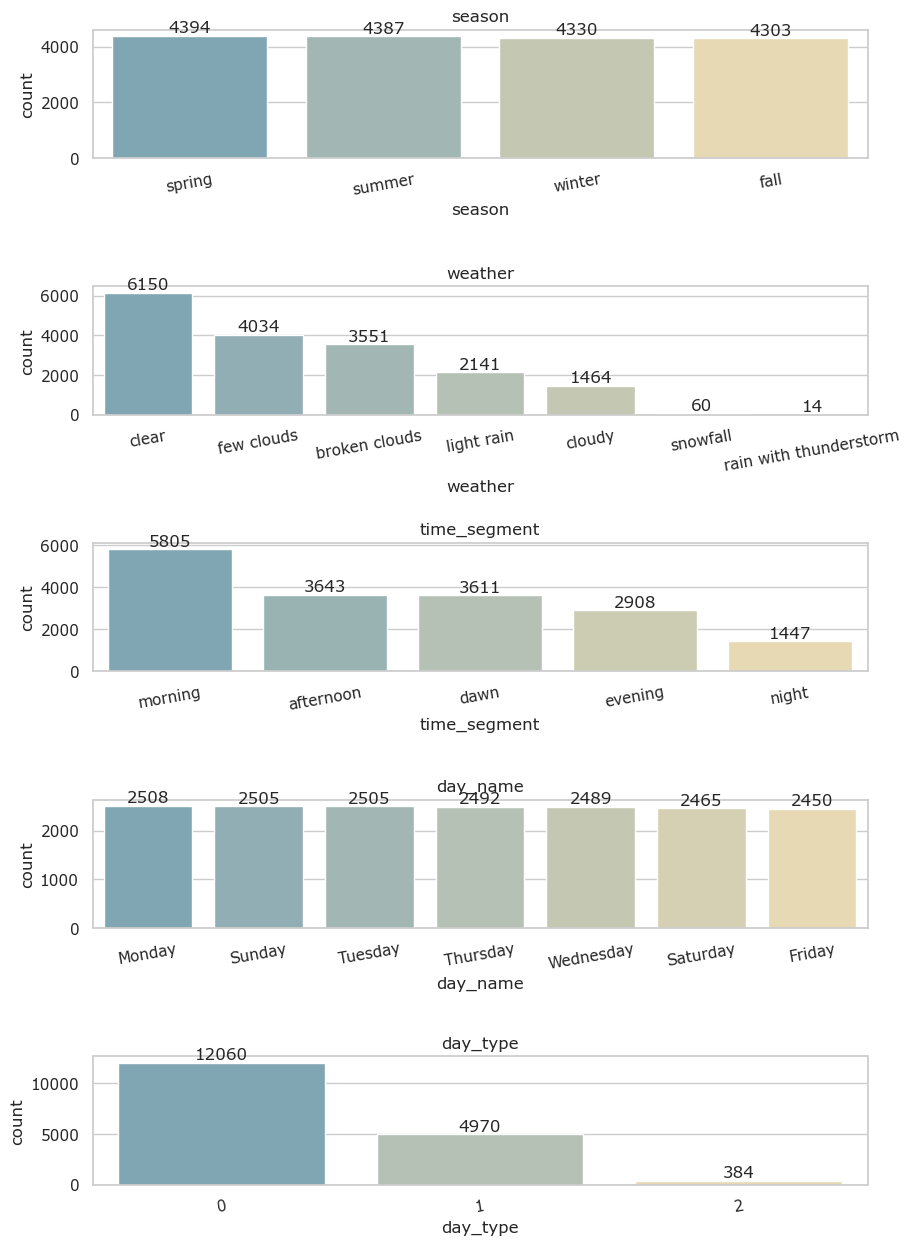

In [260]:
# Graficar los subniveles de cada variable categórica
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(cols_cat):
    sns.countplot(x=col,
                  data=df,
                  ax=ax[i],
                  order=df[col].value_counts(ascending=False).index,
                  palette=color)
    ax[i].set_title(col)
    abs_values = df[col].value_counts(ascending=False).values
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=10)
    ax[i].bar_label(container=ax[i].containers[0], labels=abs_values)

**Observaciones**

- Podemos observar que todas las columnas catégoricas tienen más de dos niveles.
- La columna **season** tiene 4 subniveles: winter, spring, summer and fall. 
- Podemos observar que el dataset contiene 384 registros de usos de bicicletas durante los días festivos y 4970 registros durante los fines de semana. 
- Existen 12060 registros de uso de bicicletas durante los días laborales.  
- La columna **weather** tiene 7 subniveles: broken clouds, clear, cloudy, light rain, few clouds, snowfall and rain with thunderstorm. Para simplificar el análisis vamos a unificar las siguientes categorias:
    * broken clouds and few clouds en una sola categoria que la llamaremos cloudy. 
    * Renombraremos la categoria light rain como rainy. 
    * Renombraremos la categoria rain with thunderstorm como rainy. 
    * Renombraremos la categoria clear como sunny 
Lo que buscamos es tener cuatro categorias  rainy, snowy, sunny, cloudy. 

In [261]:
def replace_str(prev_val, new_val, col_name):
    df[col_name] = df[col_name].str.replace(prev_val, new_val, regex=False)

In [262]:
# Unificar las categorias para la columna weather.
replace_str('broken clouds', 'cloudy', 'weather')
replace_str('few clouds', 'cloudy', 'weather')
replace_str('light rain', 'rainy', 'weather')
replace_str('rain with thunderstorm', 'rainy', 'weather')
replace_str('clear', 'sunny', 'weather')
replace_str('snowfall', 'snowy', 'weather')
print(df['weather'].unique())

['cloudy' 'sunny' 'rainy' 'snowy']


In [263]:
# Remplazar los nombres de las estaciones por variables numéricas 
replace_str('winter', "1", 'season')
replace_str('spring', "2", 'season')
replace_str('summer', "3", 'season')
replace_str('fall', "4", 'season')

df['season'] = df['season'].astype(int)
print(df['weather'].unique())

['cloudy' 'sunny' 'rainy' 'snowy']


In [264]:
print(df.groupby("year").month.count())
df.describe()

year
2015    8643
2016    8699
2017      72
Name: month, dtype: int64


,real_temperature,feeling_temperature,humidity,wind_speed,season,used_bikes,year,month,day,day_type
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,12.468091,11.520836,67.092459,15.913063,2.497473,1082.672964,2015.507810,6.514643,15.751981,0.329505
std,5.571818,6.615145,12.881867,7.894570,1.114256,1028.213239,0.508157,3.452509,8.793704,0.514829
min,-1.500000,-6.000000,20.450000,0.000000,1.000000,0.000000,2015.000000,1.000000,1.000000,0.000000
25%,8.000000,6.000000,58.700000,10.000000,2.000000,243.000000,2015.000000,4.000000,8.000000,0.000000
50%,12.500000,12.500000,69.050000,15.000000,2.000000,799.000000,2016.000000,7.000000,16.000000,0.000000
75%,16.000000,16.000000,76.700000,20.500000,3.000000,1583.750000,2016.000000,10.000000,23.000000,1.000000
max,34.000000,34.000000,92.000000,56.500000,4.000000,7447.000000,2017.000000,12.000000,31.000000,2.000000


**Observaciones**

Los datos descriptivos nos indican lo siguiente:

- La cantidad media de bicicletas usadas por día en la ciudad de Londres es de 1083 bicicletas aproximadamente. 
- La temperatura media (real_temperature) es de 12.47 grados celsius. 
- El 50% de los usuarios no utilizan la bicicleta  durante los días festivos ó fines de semana. 
- El númeero registros por año esta distribuido así: 2015: 8643 registros, año 2016: 8699 y el año 2017:72 registros correspondientes al mes de Enero.

### Revisar registros o filas repetidas 

In [265]:
print(f'Tamaño del set antes de eliminar las filas repetidas: {df.shape}')
df.drop_duplicates(inplace=True)
print(f'Tamaño del set después de eliminar las filas repetidas: {df.shape}')

Tamaño del set antes de eliminar las filas repetidas: (17414, 15)
Tamaño del set después de eliminar las filas repetidas: (17414, 15)


### Outliers en las variables numéricas

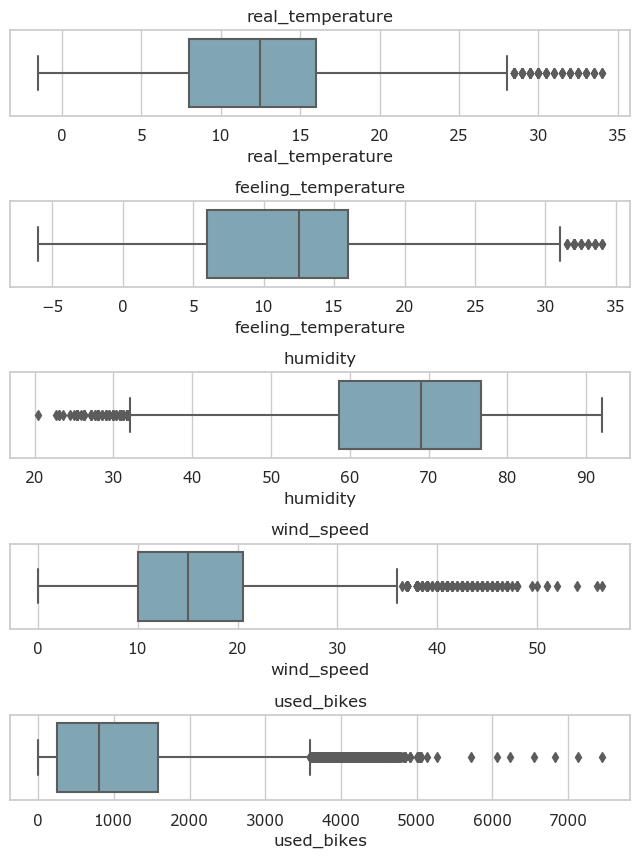

In [266]:
cols_num = [
    'real_temperature', 'feeling_temperature', 'humidity', 'wind_speed',
    'used_bikes'
]

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(8, 10))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(col)

**Observaciones**

- Observamos que existen outliers, para continuar con el análisis no vamos a realizar la eliminación de estos valores, ya que necesitamos establecer si existe alguna relación entre estos valores y los días de la semana o la estación en la que se hizo el registro. 

Se ha terminado la limpieza y el análisis preliminar del dataset ahora continuaremos con el análisis para establecer relaciones entre variables y responder las pregunta planteadas al inicio del ejercicio. 

In [267]:
final_df = df.copy()
final_df.shape

(17414, 15)

## Analizar relaciones entre variables

El objetivo del análisis es predecir el uso de bicicletas basado en los datos del dataset,  en el dataset existe un variable llamada used_bikes la cual contiene el número de bicicletas usadas por día, esta va a ser nuestra variable a predecir.  Para este análisis vamos a comparar el comportamiento del uso de bicicletas con cada variable y vamos a responder las preguntas planteadas. 

El objetivo es determinar si existe ó no relación entre las variables.  

A continuación observamos la distribucción de la variable a predecir **used_bikes** la cual al parecer no sigue una distribucción normal, vamos a realizar un test de hipótesis usando **shapiro test** para probar las siguientes hipótesis. 

<AxesSubplot: xlabel='used_bikes', ylabel='Count'>

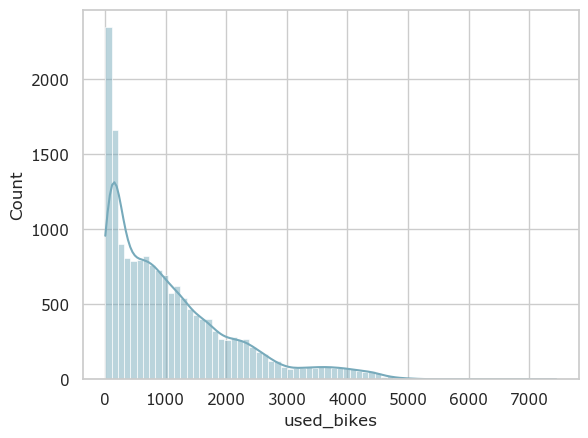

In [268]:
sns.histplot(data=final_df, x="used_bikes", kde=True)

Shapiro Test planteamientos para el test son los siguientes: 


$H_0:$ Los datos proceden de una distribucción normal $\\$ 
$H_1:$ Los datos no proceden de una distribucción normal 

$
\alpha = 0.05 \\ 
p-value < 0.05 = Rechazar H_0 \\ 
$

In [269]:
shapiro_test = shapiro(final_df["used_bikes"])
print(shapiro_test)

ShapiroResult(statistic=0.865788996219635, pvalue=0.0)


/usr/local/anaconda3/envs/uic/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


La hipótesis nula de un test de Shapiro-Wilk es que los datos proceden de una distibución normal. Con un p-valor tan bajo, rechazamos y conlcuímos que es muy improbable que estos sean datos procedentes de una distribución normal.

### ¿Cuáles son los meses en los cuales se utilizan más bicicletas?

In [270]:
def plot_used_bikes(colx_name,
                    plot_type,
                    title,
                    colx_text,
                    data=None,
                    coly_text="Cantidad de Bicicletas Usadas"):
    try:
        if (data is not None):
            group = data
        else:
            if not (colx_name in final_df.columns):
                raise IndexError
            group = final_df.groupby(colx_name).used_bikes.mean().sort_values(
                ascending=False).reset_index()
            
        if(plot_type=="reg"):
            ax = sns.regplot(x=colx_name, y="used_bikes", data=group)
        else:
            g = sns.catplot(data=group,
                            x=colx_name,
                            y="used_bikes",
                            kind=plot_type,
                            palette=color)

            g.fig.set_size_inches(12, 5)
            g.fig.subplots_adjust(top=0.81, right=0.86)

            # extract the matplotlib axes_subplot objects from the FacetGrid
            ax = g.facet_axis(0, 0)
        
        if (plot_type == "bar"):
            ax.bar_label(ax.containers[0], fontsize=8)
        ax.set_title(title, fontsize=12, fontweight="bold")
        plt.xlabel(colx_text, fontsize=10)
        plt.ylabel(coly_text, fontsize=10)
        plt.show()
    except IndexError:
        print("Variable doesn't exist in df")

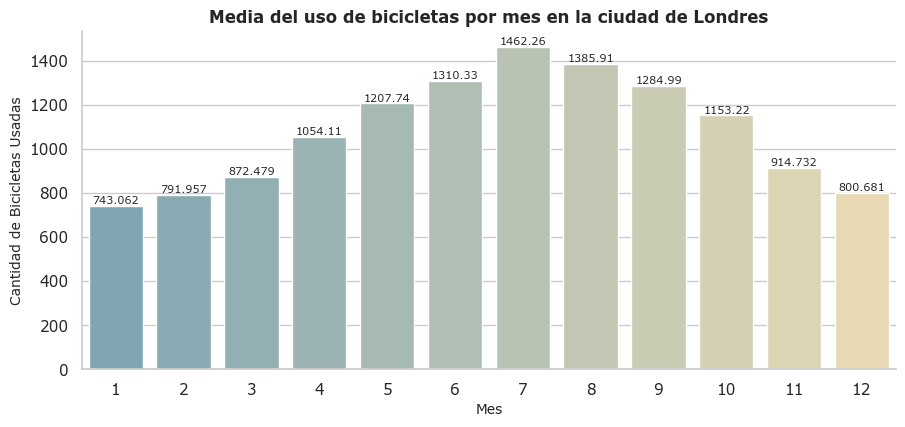

In [271]:
plot_used_bikes('month', 'bar',
                "Media del uso de bicicletas por mes en la ciudad de Londres",
                "Mes")

- Durante el mes de Julio vemos un aumento en el uso medio de bicicletas en la ciudad de Londres, con una media de 1462.26 bicicletas usadas por mes. 
- Observamos que el comportamiento del uso de bicicletas va incrementando desde el mes de Enero hasta llegar al punto máximo en Julio, a partir de Julio el uso de bicicletas empieza a decrementar. 

### ¿Cómo varia el uso de bicicletas durante el transcurso del día?**

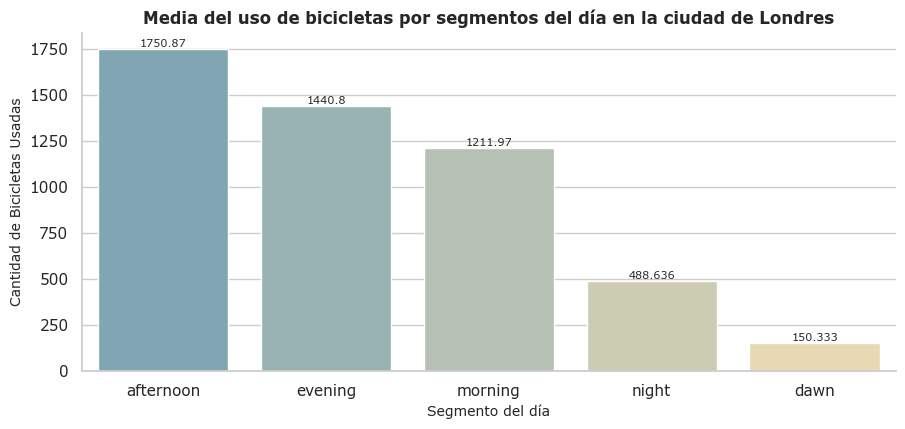

In [272]:
plot_used_bikes(
    'time_segment', 'bar',
    "Media del uso de bicicletas por segmentos del día en la ciudad de Londres",
    "Segmento del día")

- Observamos que el punto más alto del uso de bicicletas en la ciudad de Londres es el segmento clasificado como *"afternoon"*, comprendido entre las 12m hasta las 5pm, con un valor de 1750.87 bicicletas en uso. 
- En segundo lugar tenemos el segmento *"evening"*, comprendido entre las 5pm y 9pm, con un valor medio de 1440.8 bicicletas en uso. 
- Observamos una relación con estas dos variables, el uso de bicicletas va disminuyendo desde el intervalo 9 pm hasta las 4 am.   

### ¿Cómo varia el uso de bicicletas con las estaciones del año?**

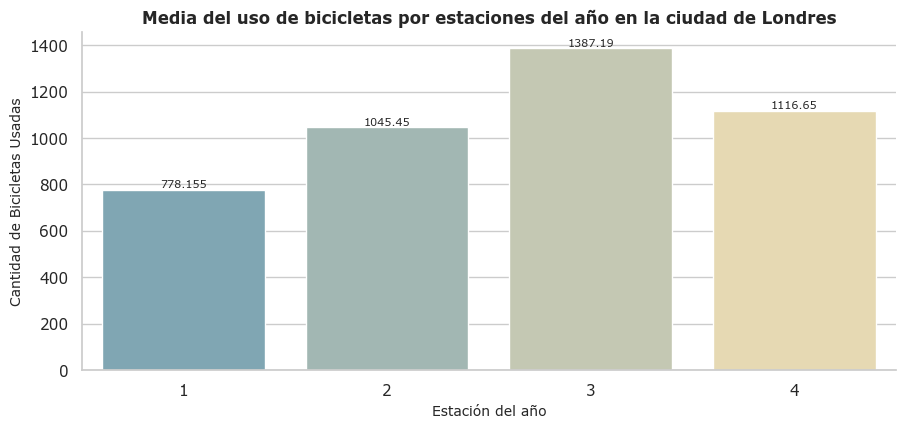

In [273]:
plot_used_bikes(
    'season', 'bar',
    "Media del uso de bicicletas por estaciones del año en la ciudad de Londres",
    "Estación del año")

- El verano es la estación del año en la que se utilizan más bicicletas por día en la ciudad de Londres, con un valor medio de 1387 bicicletas usadas por día. 
- Esto valor coincide con el mes de Julio el cuál es el mes que registra un número medio más alto en el uso de la bicicleta. 
- Observamos que el uso de las bicicletas va aumentando desde la estación de Invierno hasta llegar a un punto máximo durante el verano, luego empieza a decrecer a medida que va llegando el otoño. 

### ¿Cómo afecta el clima el uso de la bicicleta?

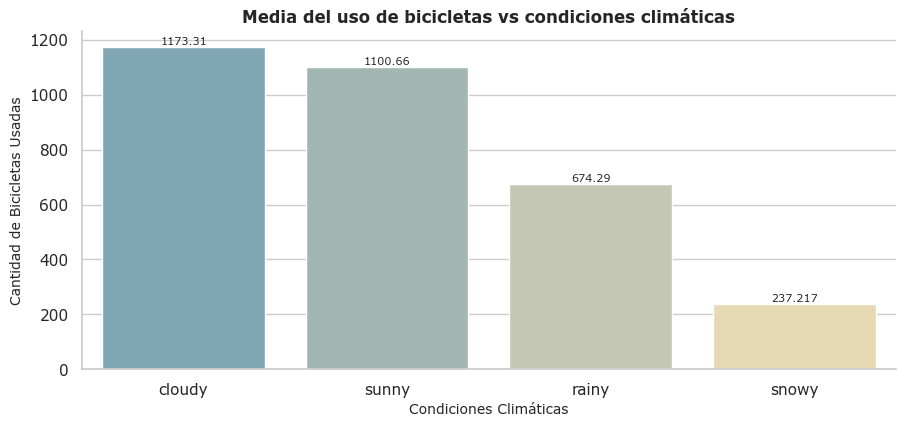

In [274]:
plot_used_bikes('weather', 'bar',
                "Media del uso de bicicletas vs condiciones climáticas",
                "Condiciones Climáticas")

- El uso de bicicletas aumenta cuando el clima esta nubado, la media de uso es 1173 bicicletas por día.  
- Cuando los días son soleados el uso medio de bicicletas es dee 1101 bicicletas por día. 
- Cuando las condiciones climáticas son lluviosas o con caida de nieve el uso de bicicletas disminuye significativamente. 

### ¿Cuando se usan más bicicletas durante el fin de semana, festivos o en los días laborales?

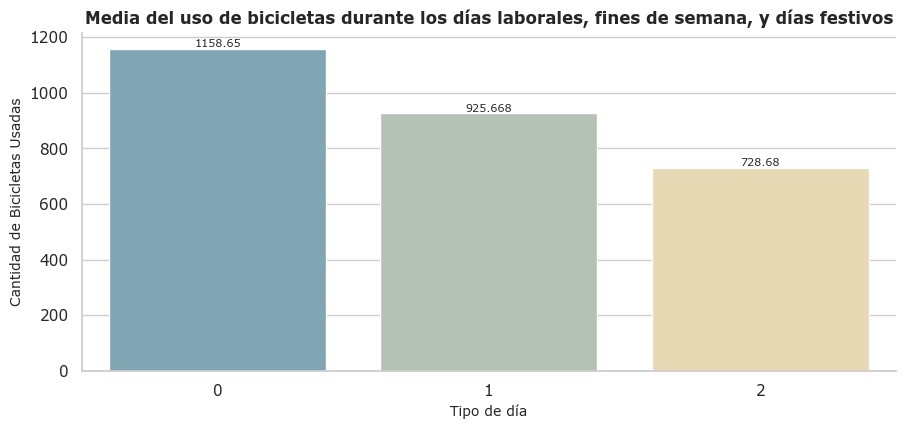

In [275]:
plot_used_bikes(
    'day_type', 'bar',
    "Media del uso de bicicletas durante los días laborales, fines de semana, y días festivos",
    "Tipo de día")

- Los días laborales de Lunes a Viernes son los días en los cuales se usan mas bicicletas con una media de 1158.65 por día. 
- En segundo lugar se encuentran los días festivos con una media de 925.66 bicicletas usadas por día. 
- Podriamos decir que existe una disminución en el uso de la bicicleta durante los fines de semana y festivos en comparación con los días laborales. 

### ¿Cuál es el día de la semana en el que más se usan bicicletas?

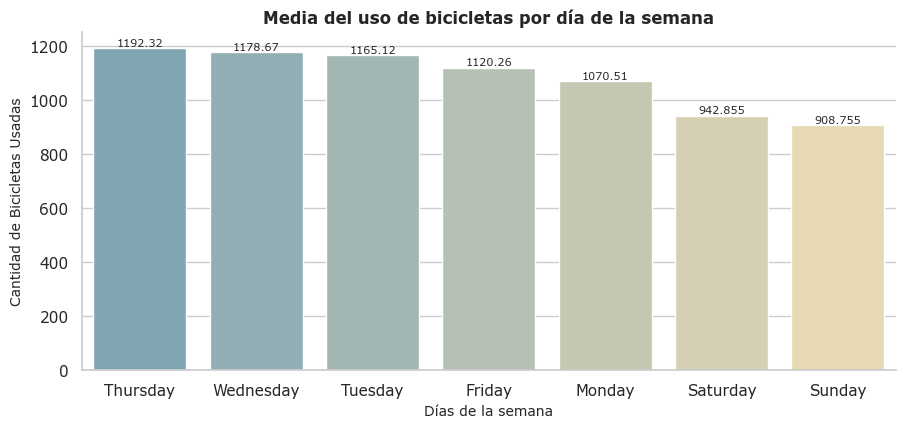

In [276]:
plot_used_bikes('day_name', 'bar', "Media del uso de bicicletas por día de la semana", "Días de la semana")

- El Jueves es el día en el que aumenta el uso de bicicletas en la ciudad de Londres.  En promedio se usan 1119 bicicletas. 
- Los fines de semana el uso disminuye, esto coincide con el grafico del uso durante los días festivos y fines de semana, en los que notabamos una disminución significativa del uso. 

### ¿Afecta la temperatura en el uso de la bicicleta?

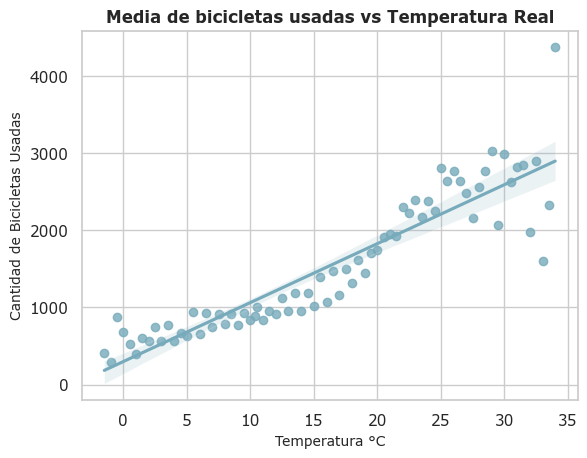

In [277]:
plot_used_bikes('real_temperature', 'reg',
                "Media de bicicletas usadas vs Temperatura Real", "Temperatura °C")

In [ ]:
plot_used_bikes('feeling_temperature', 'reg',
                "Media de bicicletas usadas vs Sensación Térmica", "Sensación Térmica °C")

- Observamos que existe una relación incremental entre el uso de bicicletas y la sensación térmica.  
- A mayor temperatura el uso de bicicletas parece incrementar,  sin embargo existen unos valores superiores a la media en el uso de las bicicletas.   

### ¿Afecta la humedad el uso de la bicicleta?

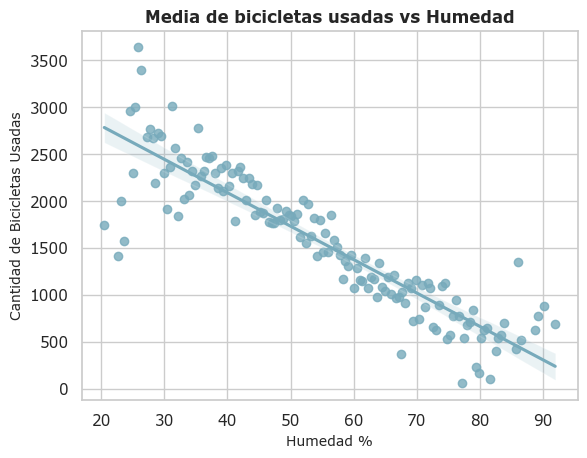

In [278]:
plot_used_bikes('humidity', 'reg',
                "Media de bicicletas usadas vs Humedad", "Humedad %")

- Se observa que al aumentar el porcentaje de humedad, el uso de bicicletas disminuye, parece indicar que existe una correlación negativa entre estas dos variables. 

### ¿Se ha aumentado el uso de bicicletas en Londres a traves del tiempo?

Text(0.5, 1.0, 'Bicicletas usadas por meses en los años 2015 y 2016')

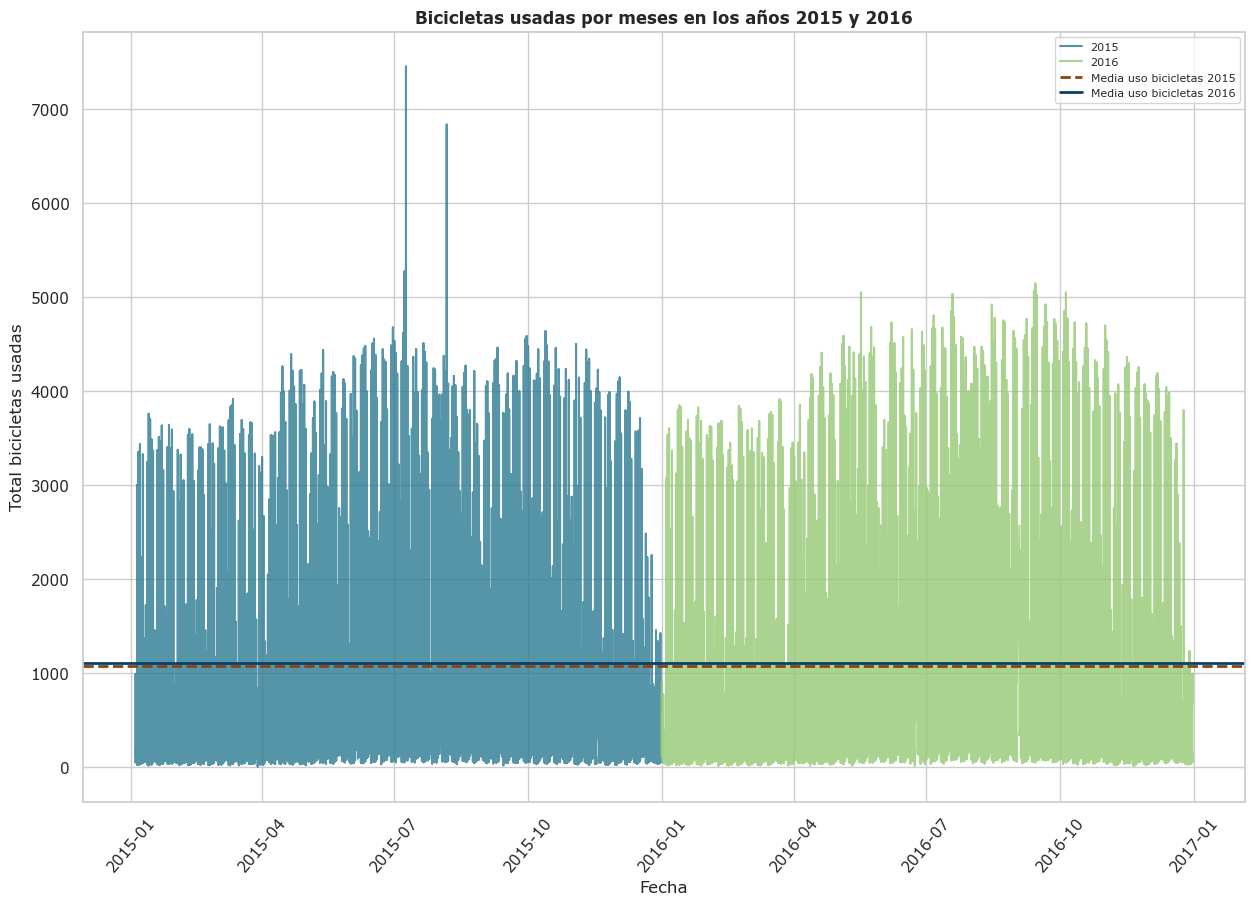

In [279]:
date_2015 = final_df[final_df['date'].between('2015-01-01', '2015-12-31')]
date_2016 = final_df[final_df['date'].between('2016-01-01', '2016-12-31')]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
# Plot all the data as lines
plt.plot(date_2015['date'],
         date_2015['used_bikes'],
         '#2c7b92',
         label='2015',
         alpha=0.80)

plt.plot(date_2016['date'],
         date_2016['used_bikes'],
         '#94C973',
         label='2016',
         alpha=0.8)
plt.axhline(date_2015['used_bikes'].mean(),
            linestyle="--",
            color='#8B4411',
            linewidth=2,
            label="Media uso bicicletas 2015")
plt.axhline(date_2016['used_bikes'].mean(),
            linestyle="-",
            color='#05426D',
            linewidth=2,
            label="Media uso bicicletas 2016")
# Formatting plot
plt.legend()
plt.legend(fontsize=8)
plt.xticks(rotation=50)

# Lables and title
plt.xlabel('Fecha')
plt.ylabel('Total bicicletas usadas')
plt.title('Bicicletas usadas por meses en los años 2015 y 2016', fontweight="bold")

- Se observa un aumento muy moderado en el uso de bicicletas entre el año 2015 y 2016. La media para el año 2016 fue de 1102 y para el año 2015 fue de 1067. 
- En la gráfica observamos que los meses de verano el uso de bicicletas se incrementa como vimos en las gráficas del comportamiento por estaciones.  
- Observamos unos valores extremos en el año 2015 en el mes de Julio. Vamos a filtrar los datos para obtener los registros que correspondan a estos valores extremos con el fin de verificar que condiciones tienen y tomar una decisión de eliminarlos ó no. 

**Nota:**
- El año 2017 solo tiene registros del mes de Enero, para esta pregunta no lo incluimos para ver la tendencia anual.

In [280]:
# Filtrar valores extremos del año 2015 observado en la gráfica, para estos vamos a filtrar used_bikes mayor a 5000. 

extreme_values = date_2015[date_2015['used_bikes']>5000].reset_index()
print(extreme_values)

   index  real_temperature  feeling_temperature  humidity  wind_speed weather  \
0   4446              20.0                 20.0     49.70        30.0  cloudy   
1   4460              13.5                 13.5     60.50        17.0   sunny   
2   4461              14.5                 14.5     56.90        19.0  cloudy   
3   4469              23.0                 22.0     25.40        11.0   sunny   
4   4470              23.0                 22.0     26.30        11.0   sunny   
5   4471              22.5                 21.5     28.10        13.0   sunny   
6   5129              19.0                 19.0     72.20        12.0   rainy   
7   5138              22.5                 22.5     51.50        17.5  cloudy   
8   5139              21.5                 21.5     54.65        20.0  cloudy   

   season  used_bikes       date      time time_segment  year  month  \
0       3        5268 2015-07-08  17:00:00    afternoon  2015      7   
1       3        5030 2015-07-09  07:00:00   

- Al realizar un filtro de la columna **used_bikes** que contiene la cantidad de bicicletas usadas, se observa que existen 9 registros con valores superiores a 5000, estos valores se ubican en los meses de verano por lo cual no nos pareceria extraño ya que el verano se presenta un incremento significativo en el uso de bicicletas. 

- Tendriamos que tener un poco mas de contexto para verificar que paso durante esos días que haya causado un aumento en el uso de bicicletas, pero al buscar en google, no se encontro algún evento en particular que pudo afectar este aumento.   Sin embargo al no tener suficiente contexto para decidir si eliminarlos ó no, vamos a continuar el análisis con estos valores extremos. 

###  Contraste de Hipótesis 

Vamos a verificar con un contraste de hipótesis la siguiente hipótesis: 

$$
H_0: \mu uso bicicletas 2015  = \mu  uso biciletas 2016 \\ 
H_1: \mu uso bicicletas 2015  \neq \mu uso biciletas 2016  \\ 
$$

Si el p-value que obtenemos en el test es menor que $\alpha = 0.05$ podemos rechazar la hipótesis Nula y decir que existe una diferencia significativa.

In [281]:
from scipy.stats import mannwhitneyu

print(
    mannwhitneyu(date_2015['used_bikes'].mean(),
                 date_2016['used_bikes'].mean()))

MannwhitneyuResult(statistic=0.0, pvalue=1.0)


Los p-values del test de U-Whitmann son mayores que el nivel de significancia por lo tanto, podemos decir que no existe una diferencia entre los valores medios del uso de bicicletas entre el año 2015 y 2016. 

### Matriz de correlación

- Para establecer si las relaciones positivas o negativas observadas mediante las gráficas corresponden a la realidad, vamos a realizar un análisis de la correlación usando el método **spearman** para distribucciones no normales.  

- Luego vamos a graficar la matriz de correlación y establecer cuales variables tienen una correlación significativa.  Vamos a considerar significativa una correlación positiva ó negativa >= 0.5


<AxesSubplot: >

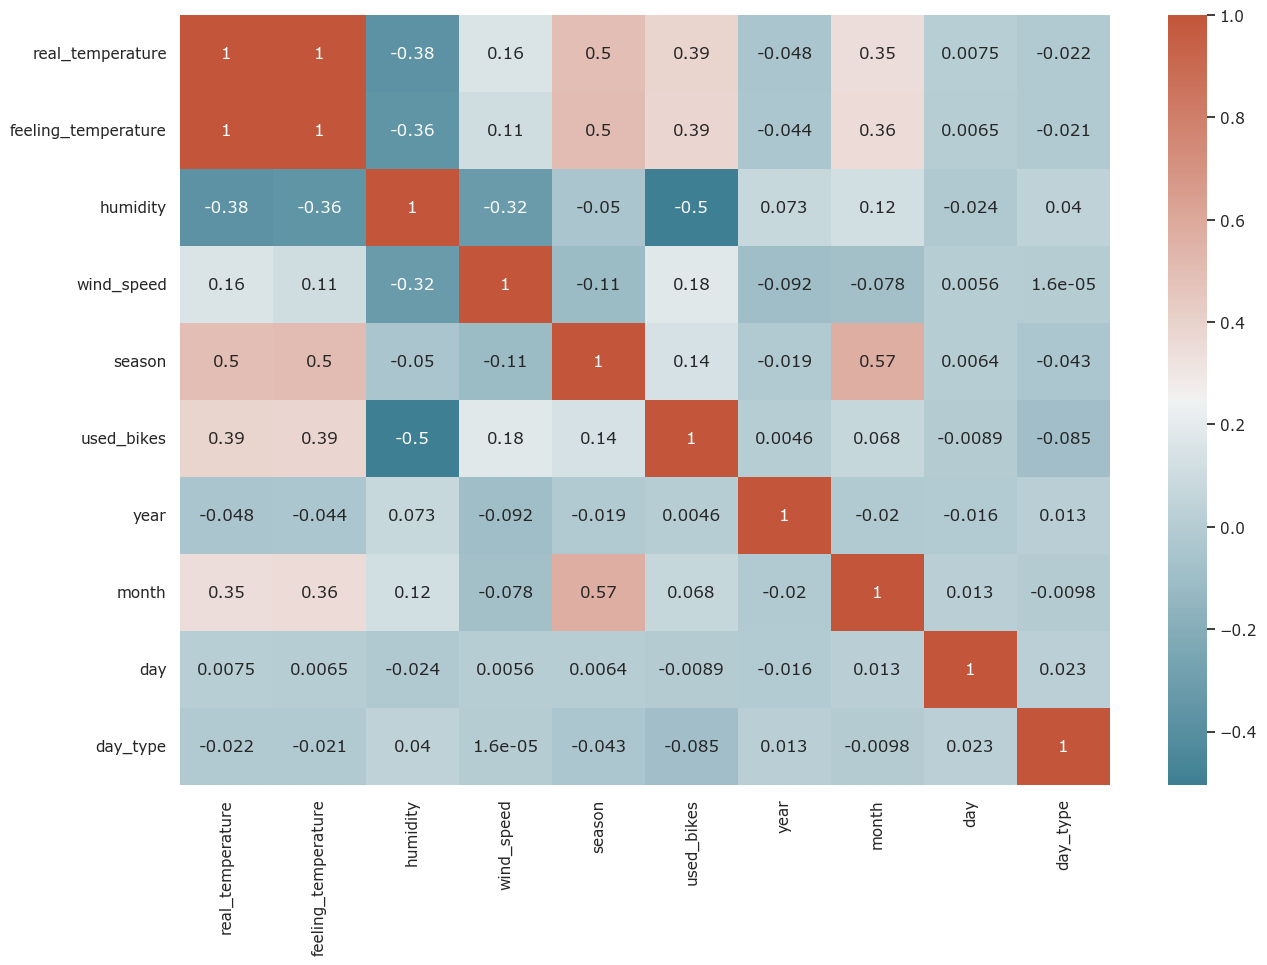

In [156]:
plt.figure(figsize=(15, 10))
corr = final_df.corr(method="spearman", numeric_only=True)
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True))

#### Variables con correlación positiva y negativa

|        **Correlación Positiva**        | **Valor** |
|:--------------------------------------:|-----------|
| feeling_temperature - real_temperature |  0.995809 |
| season and month                       |  0.573461 |
| season and feeling_temperature         |  0.500545 |


| **Correlación Positiva** | **Valor**  |
|:------------------------:|------------|
| used_bikes and humidity  |  -0.504619 |

## Conclusiones del EDA

Existen variables que impactan en el uso de bicicletas en la ciudad de Londres como son: 

1. **Factores Estacionales**
    - El mes de Junio es el mes en que se incrementa el uso de la bicicleta. 
    - El verano es la estación donde se incrementa el uso de bicicletas.
    - Existe una correlación de 0.573461 entre las variables season and month. 
    - Existe una correlación de 0.500545 entre las variables season and feeling_temperature. 
    - Existe una correlación de 0.995809 entre las variables feeling_temperature and real_temperature. 
    

2. **Factores Horarios**
    - El segmento del día en el que se incrementa el uso de bicicletas es en la franja horaria de 12m hasta las 5pm. 
    - Los días laborales son los días en los que más se utilizan bicicletas. 
    - El Jueves es el día en el que aumenta el uso de bicicletas en la ciudad de Londres. 
    

3. **Factores Meterelogicos** 
    - El uso de bicicletas es mayor cuando las condiciones metereólogicas son nubladas y con altas temperaturas. 
    - La temperatura real y la sensación térmica tienen un impacto en el uso de bicicletas.
    - La humedad tiene una correlación negativa de -0.504619 con el uso de bicicletas, esto quiere decir que a menor humedad el uso de bicicletas aumenta. 
    
       
6. No se encontraron unas correlaciones positivas ó negativas muy fuertes entre las variables del dataset.  

7. El uso de bicicletas se ve afectado por los cambios en el clima, para realizar un modelo para predecir el uso de las bicicletas podemos incluir los factores metereologicos para obtener una prevision más precisa. 

## Creación de un modelo 

-  Vamos a realizar un modelo para predecir el uso de bicicletas, utilizando las variables metereologicas contenidas en el dataset y las variables de tipo estacional.  
- Primero vamos a crear un nuevo dataframe con las columnas que vamos a utilizar. 

In [235]:
model_data = final_df[[
    "weather", "real_temperature", "feeling_temperature", "month", "humidity",
    "season", "time_segment", "day_type", "used_bikes", "time", 'wind_speed'
]]
model_data.shape

(17414, 11)

### One-hot-encoding para variables categoricas. 

- Vamos a utilizar la función get_dummies para hacer one-hot-encoding para las variables categoricas **weather, time_segment, and time**

In [236]:
model_data = pd.get_dummies(model_data)
# Display the first 5 rows
model_data.iloc[:, 5:].head(5)

,day_type,used_bikes,wind_speed,weather_cloudy,weather_rainy,weather_snowy,weather_sunny,time_segment_afternoon,time_segment_dawn,time_segment_evening,...,time_14:00:00,time_15:00:00,time_16:00:00,time_17:00:00,time_18:00:00,time_19:00:00,time_20:00:00,time_21:00:00,time_22:00:00,time_23:00:00
0,1,172,6.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,130,5.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,126,0.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,68,0.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,44,6.5,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
# Mover la ultima columna used_bikes que es la columna a predecir al final del dataset. 
used_bikes_col = model_data.pop('used_bikes')
model_data = pd.concat([model_data, used_bikes_col], 1)

/var/folders/1b/q0vy8pzj2d5_w7tb8dkfmh2m0000gn/T/ipykernel_74846/3039058788.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  model_data = pd.concat([model_data, used_bikes_col], 1)


## Separar el dataset en  Training set y Test set

- Para hacer la separación del dataset, vamos a utilizar el 20% de los datos que corresponde a 3483 registros como test_set y 13931 registros para training_set. 

- Para realizar la predicción vamos a utilizar el algoritmo Random Forest Regression. 

In [238]:
X = model_data.iloc[:, :-1].values
y = model_data.iloc[:, -1].values

In [239]:
# Splitting the dataset into training and testing set (80/20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0)

## Entrenar el Ramdon Forest Regressor model con el training set. 

In [240]:
from sklearn.ensemble import RandomForestRegressor
# Initializing the Random Forest Regression model with 10 decision trees
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# Fitting the Random Forest Regression model to the data
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [241]:
# Predicting the target values of the test set
y_pred = regressor.predict(X_test)

## Mean Squared Error and R2 Score

In [242]:
from sklearn.metrics import mean_squared_error 

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ", np.round(rmse, 2))

RMSE:  249.51


In [243]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y_pred))

0.9420681527393305


- El RMSE es de 249.51 es la desviación estándar que existe entre el valor predicted y el valor real de la variable target, para establecer si este valor es aceptable debemos realizar más iteraciones del modelo.
- El R2 score es de 94%, esto quiere decir que el 94% de la variabilidad observada en la variable a predecir **used_bikes** se explica con el modelo de regresión. 

## Visualizar los resultados  del Random Forest Regression

- A continuación vemos los datos reales del training set y los valores predicted. Con el fin de comparar el nivel de acierto del modelo. 

In [285]:
df = pd.DataFrame({
    'Valores Reales': y_test.reshape(-1),
    'Predicted': y_pred.reshape(-1)
})
df

,Valores Reales,Predicted
0,668,544.77
1,907,943.81
2,470,504.53
3,1319,1273.47
4,2911,2941.10
...,...,...
3478,732,505.12
3479,109,123.86
3480,323,258.59
3481,4203,4137.34


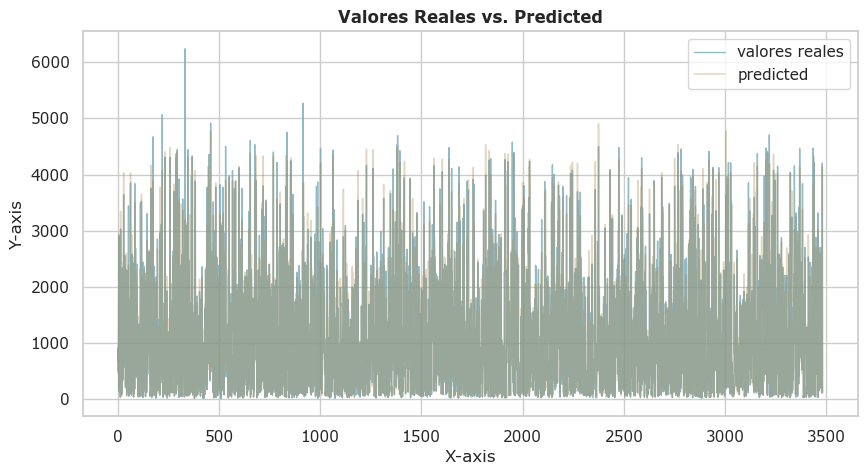

In [284]:
# Plot the results
plt.figure(figsize=(10, 5))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, alpha=0.8, linewidth=1, label="valores reales")
plt.plot(x_ax,
         y_pred,
         alpha=0.3,
         linewidth=1.1,
         label="predicted",
         color='#a87932')
plt.title("Valores Reales vs. Predicted", fontweight="bold")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best', fancybox=True, shadow=False)
plt.grid(True)
plt.show()